In [106]:
# Import required libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt




## Summary: Two-Stage kNN Results

- Stage 1 classified between Class 0 (No Diabetes) and Class 1/2 (At-Risk).
- Stage 2 refined predictions between Class 1 (Prediabetes) and Class 2 (Diabetes).
- This approach aimed to improve sensitivity to underrepresented classes.

**Key Observations:**
- Class 0 had strong accuracy in Stage 1.
- Class 1 (Prediabetes) remained difficult to predict, likely due to class imbalance.
- Overall, the two-stage model improved recall and AUC for Class 2 (Diabetes) over the one-stage baseline.


In [107]:
file_path = "../data/cleaned_diabetes_health_indicators_dataset.csv"
df = pd.read_csv(file_path)

## Section 1: One-Stage kNN Classification
This section trains and evaluates a single kNN model on the original 3-class diabetes target (0 = No Diabetes, 1 = Prediabetes, 2 = Diabetes).


In [108]:
# Separate features and target for original 3-class classification
X = df.drop("Diabetes_012", axis=1)
y = df["Diabetes_012"]


In [109]:
# Standardize features and split dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [110]:
# Train a one-stage kNN classifier (multiclass)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90     38012
         1.0       0.05      0.00      0.00       926
         2.0       0.41      0.21      0.27      7019

    accuracy                           0.82     45957
   macro avg       0.44      0.39      0.39     45957
weighted avg       0.77      0.82      0.78     45957



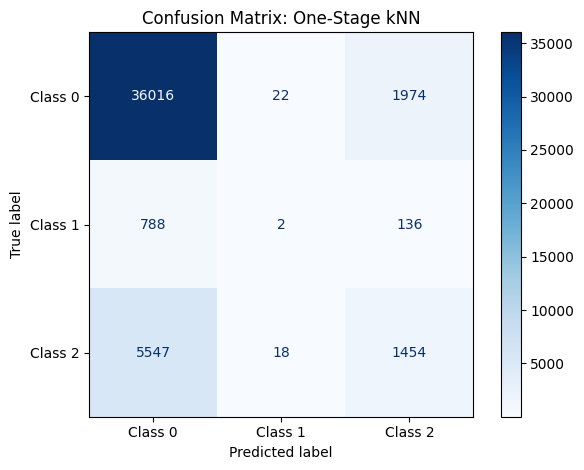

In [111]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1", "Class 2"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix: One-Stage kNN")
plt.grid(False)
plt.tight_layout()
plt.show()


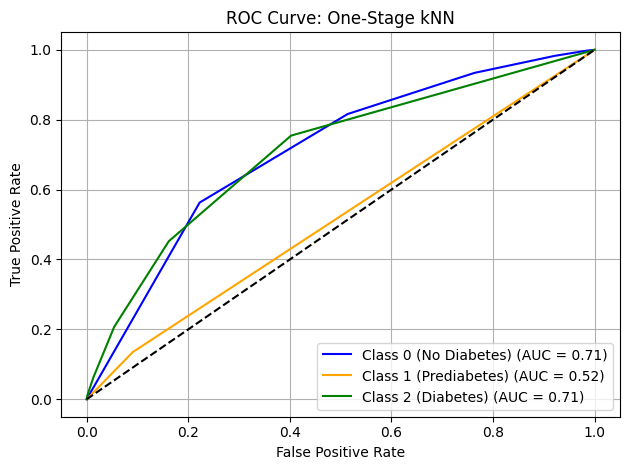

In [112]:
# Predict probabilities for ROC curve
y_proba = knn.predict_proba(X_test)

# Binarize true labels
y_bin = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = ['blue', 'orange', 'green']
labels = ['Class 0 (No Diabetes)', 'Class 1 (Prediabetes)', 'Class 2 (Diabetes)']

for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: One-Stage kNN")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [113]:
# Separate input features and target column
X = df.drop("Diabetes_012", axis=1)
y = df["Diabetes_012"]


## Section 2: Two-Stage kNN Classification


In [114]:
# Combine classes 1 and 2 into a single "At-Risk" group for binary classification
y_binary = y.copy()
y_binary[y_binary == 2] = 1


In [115]:
# Standardize feature values to improve kNN performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [116]:
# Split data into training and testing sets
X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    X_scaled, y_binary, test_size=0.2, stratify=y_binary, random_state=42
)

# Also split the original y for multiclass labels
_, _, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y_binary, random_state=42
)

# Reset indexes to ensure alignment for filtering later
y_train_binary = y_train_binary.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


In [117]:
# Train the first kNN model to separate No Diabetes (0) vs At-Risk (1 or 2)
knn_stage1 = KNeighborsClassifier(n_neighbors=5)
knn_stage1.fit(X_train, y_train_binary)
y_pred_binary = knn_stage1.predict(X_test)


In [118]:
# Evaluate Stage 1 model performance
print("Stage 1: Classification Report (0 vs 1+2)")
print(classification_report(y_test_binary, y_pred_binary))
print("Confusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_binary))
print("ROC AUC:", roc_auc_score(y_test_binary, knn_stage1.predict_proba(X_test)[:, 1]))


Stage 1: Classification Report (0 vs 1+2)
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89     38012
         1.0       0.42      0.24      0.30      7945

    accuracy                           0.81     45957
   macro avg       0.64      0.58      0.60     45957
weighted avg       0.78      0.81      0.79     45957

Confusion Matrix:
[[35413  2599]
 [ 6060  1885]]
ROC AUC: 0.7106528977269078


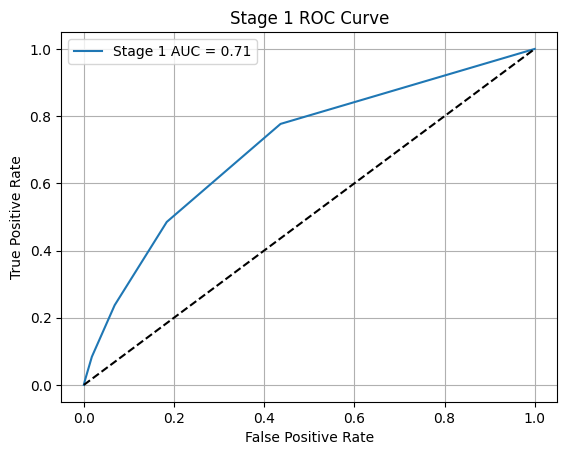

In [119]:
# Plot ROC curve for Stage 1
fpr1, tpr1, _ = roc_curve(y_test_binary, knn_stage1.predict_proba(X_test)[:, 1])
plt.plot(fpr1, tpr1, label=f"Stage 1 AUC = {roc_auc_score(y_test_binary, knn_stage1.predict_proba(X_test)[:, 1]):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Stage 1 ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [120]:
# Get original multiclass labels for Stage 2 evaluation
y_test_full = y.iloc[y_test_binary.index]


In [121]:
# Get test samples predicted as At-Risk (1) by Stage 1 model
indices_pred_diabetes = np.where(y_pred_binary == 1)[0]
X_test_diabetes = X_test[indices_pred_diabetes]
y_test_diabetes = y_test_full.iloc[indices_pred_diabetes]


In [122]:
# Keep only samples where true class is 1 or 2
mask_12 = (y_test_diabetes == 1) | (y_test_diabetes == 2)
X_test_diabetes = X_test_diabetes[mask_12]
y_test_diabetes = y_test_diabetes[mask_12]


In [123]:
# Use original training data where binary label was 1 (i.e., class 1 or 2)
X_train_diabetes = X_train[y_train_binary == 1]
y_train_diabetes = y[y_binary == 1]


In [124]:
# Filter training labels to match X_train_diabetes
# This ensures both features and labels have the same number of rows and correspond to class 1 or 2
y_train_diabetes = y_train[y_train_binary == 1]

# Train the second-stage kNN model to know between prediabetes (1) and diabetes (2)
knn_stage2 = KNeighborsClassifier(n_neighbors=5)
knn_stage2.fit(X_train_diabetes, y_train_diabetes)
y_pred_second_stage = knn_stage2.predict(X_test_diabetes)



In [125]:
# Evaluate Stage 2 predictions (1 = prediabetes, 2 = diabetes)
print("Stage 2: Classification Report (1 vs 2)")
print(classification_report(y_test_diabetes, y_pred_second_stage))
print("Confusion Matrix:")
print(confusion_matrix(y_test_diabetes, y_pred_second_stage))
print("ROC AUC:", roc_auc_score(y_test_diabetes, knn_stage2.predict_proba(X_test_diabetes)[:, 1]))


Stage 2: Classification Report (1 vs 2)
              precision    recall  f1-score   support

         1.0       0.07      0.01      0.01       170
         2.0       0.91      0.99      0.95      1715

    accuracy                           0.90      1885
   macro avg       0.49      0.50      0.48      1885
weighted avg       0.83      0.90      0.86      1885

Confusion Matrix:
[[   1  169]
 [  13 1702]]
ROC AUC: 0.4884873949579832


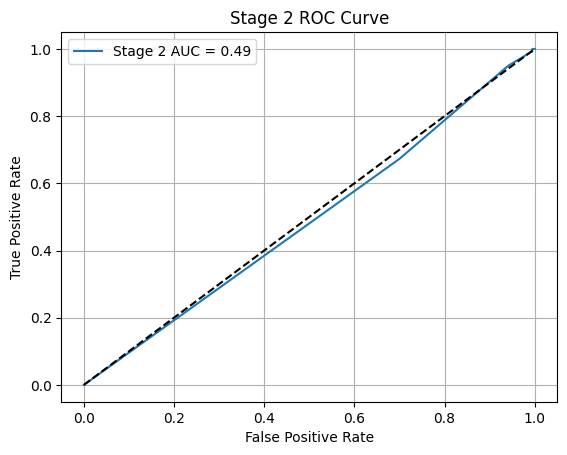

In [126]:
# Convert labels to binary: 0 = prediabetes, 1 = diabetes
y_test_diabetes_binary = y_test_diabetes - 1

# Plot ROC curve for Stage 2
fpr2, tpr2, _ = roc_curve(y_test_diabetes_binary, knn_stage2.predict_proba(X_test_diabetes)[:, 1])
plt.plot(fpr2, tpr2, label=f"Stage 2 AUC = {roc_auc_score(y_test_diabetes_binary, knn_stage2.predict_proba(X_test_diabetes)[:, 1]):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Stage 2 ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
